In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from IPython.display import display
from tqdm.notebook import tqdm 
%config InlineBackend.figure_format = 'retina'

In [2]:
def Pi(p:np.ndarray) -> np.ndarray:
    """convert from homogeneous coordinates to inhomogeneous coordinates

    subtract one coordinate"""
    if isinstance(p, np.ndarray):
        return p[:-1]/p[-1]
    elif isinstance(p, list):
        return [Pi(np.array(p_)) for p_ in p]

def PiInv(p:np.ndarray) -> np.ndarray:
    """convert from inhomogeneous coordinates to homogeneous coordinates

    add one coordinate with value 1"""
    if isinstance(p, np.ndarray):
        return np.vstack((p, np.ones(p.shape[1])))
    elif isinstance(p, list):
        return [PiInv(np.array(p_)) for p_ in p]

def projectpoints(K, R, t, Q):
    """project 3D points to 2D"""
    Rt = np.concatenate((R, t), axis=1)
    return Pi(K @ Rt @ PiInv(Q))
    
def crossOp(a:np.ndarray) -> np.ndarray:
    """crossproduct operator"""
    x = a[0].item()
    y = a[1].item()
    z = a[2].item()
    return np.array([[0, -z, y], [z, 0, -x], [-y, x, 0]])

def compute_fundamental_matrix(K1, K2, R2, t2):
    """compute fundamental matrix from camera matrices"""
    E = crossOp(t2) @ R2
    F = np.linalg.inv(K2).T @ E @ np.linalg.inv(K1)
    return F

In [3]:
# 9.1
def Fest_8point(q1:np.ndarray, q2:np.ndarray) -> np.ndarray:
    """compute fundamental matrix from 8 point correspondences
    points: list of tuples of 2d points (q1, q2)"""
    N = q1.shape[1]
    K = q1.shape[0]
    B = np.zeros((N, K**2))
    for i, (q1, q2) in enumerate(zip(q1.T, q2.T)):
        q1 = q1.reshape(-1, 1) # make column vector to make the matrix multiplication work
        q2 = q2.reshape(-1, 1)
        B[i, :] = (q2 @ q1.T).flatten()
    U, S, Vh = np.linalg.svd(B)
    V = Vh.T
    F = V[:,-1].reshape(3, 3)
    return F

test_p = np.load('data/Fest_test.npy', allow_pickle=True).item()
q1, q2, Ftrue = test_p['q1'], test_p['q2'], test_p['Ftrue']

Fest = Fest_8point(q1, q2)

In [4]:
# at det er det samme
Ftrue = Ftrue / - np.linalg.norm(Ftrue, 'fro')
display(np.linalg.norm(Ftrue))
Fest, Ftrue

1.0

(array([[-3.07914555e-08,  3.61883689e-06, -5.43583727e-04],
        [ 4.49876682e-06,  2.24402705e-08, -1.51520136e-01],
        [-1.95223414e-03,  1.48295604e-01,  9.77264527e-01]]),
 array([[-3.07914555e-08,  3.61883689e-06, -5.43583727e-04],
        [ 4.49876682e-06,  2.24402705e-08, -1.51520136e-01],
        [-1.95223414e-03,  1.48295604e-01,  9.77264527e-01]]))

In [5]:
data = np.load('data/TwoImageData.npy', allow_pickle=True).item()
im1, im2, R1, R2, t1, t2, K = data['im1'], data['im2'], data['R1'], data['R2'], data['t1'], data['t2'], data['K']

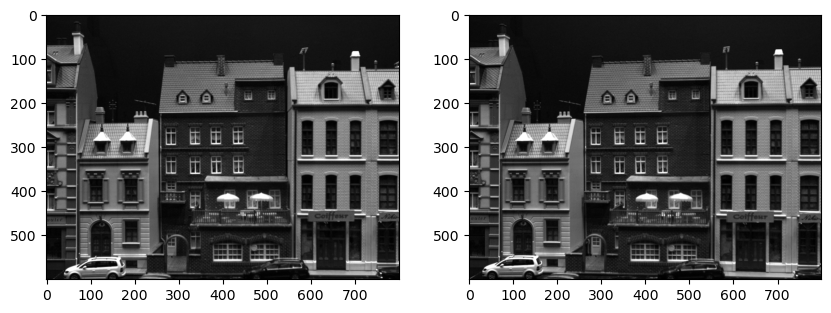

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(im1,cmap='gray')
ax[1].imshow(im2,cmap='gray')

In [7]:
# 9.2
# Applying SIFT detector
sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(im1, None)
kp2, des2 = sift.detectAndCompute(im2, None)

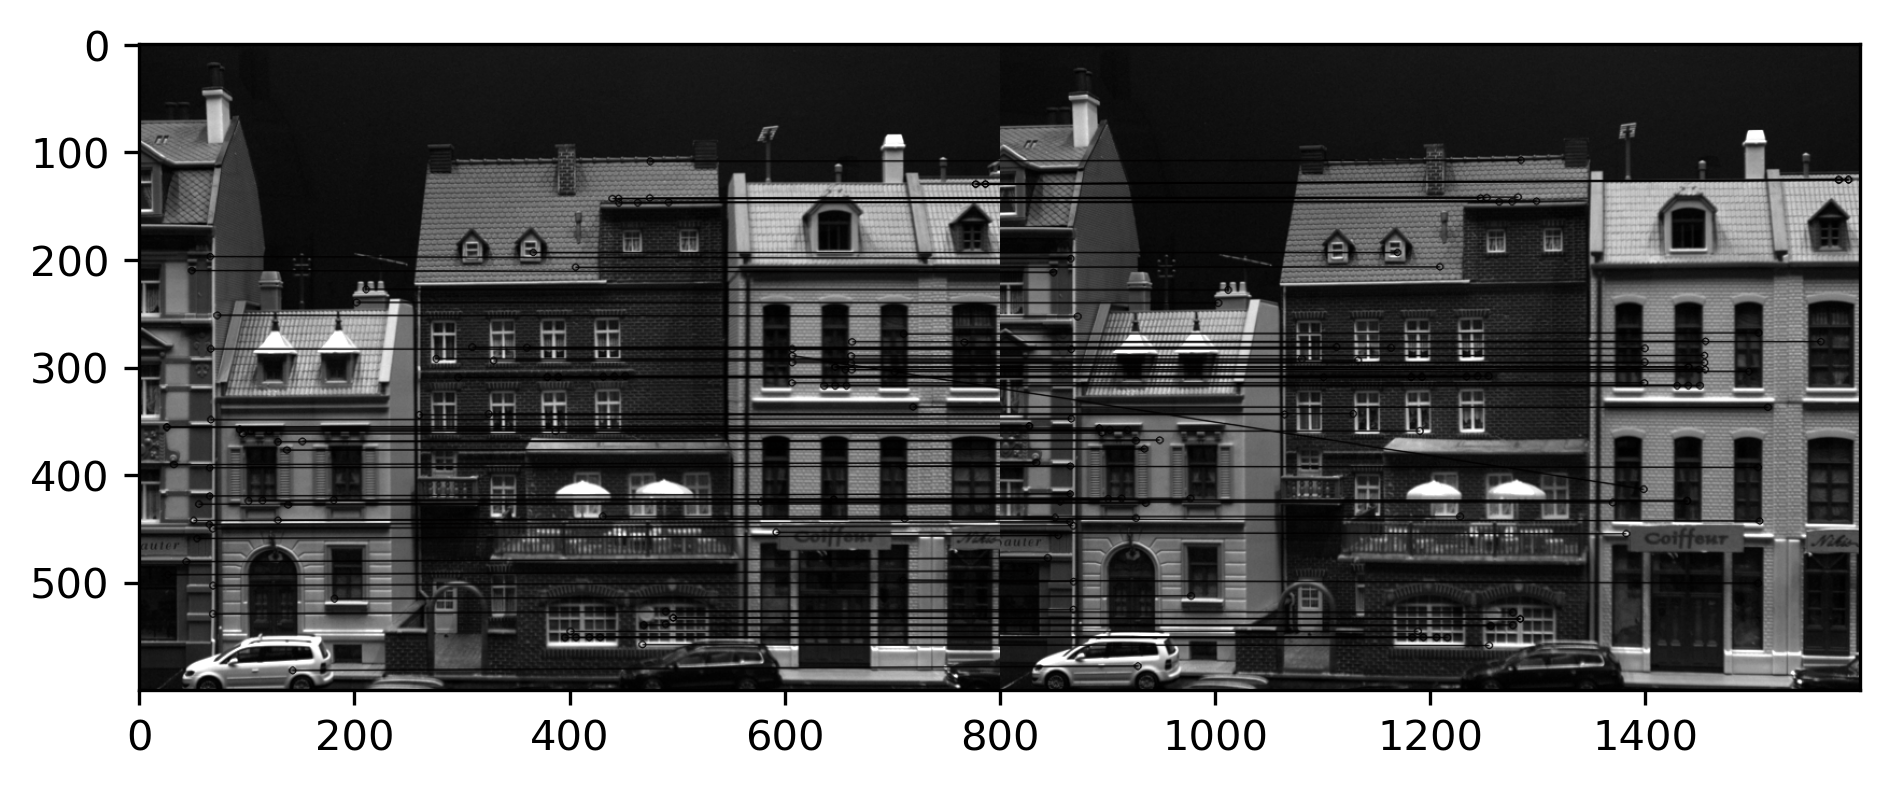

In [8]:
bf = cv2.BFMatcher_create(crossCheck=True)
matches = bf.match(des1, des2)
# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)
# draw first 100 matches. to not pollute the image too much
img3 = cv2.drawMatches(im1, kp1, im2, kp2, matches[:100], None, 1, flags=2)
fig, ax = plt.subplots(dpi=300, tight_layout=True)
ax.imshow(img3, cmap='gray');

In [9]:
# 9.3
eight_random_matches = np.random.choice(matches, 8, replace=False)
eight_random_matches

array([< cv2.DMatch 0000019CF3924790>, < cv2.DMatch 0000019CF392CE70>,
       < cv2.DMatch 0000019CF39250B0>, < cv2.DMatch 0000019CF392B9B0>,
       < cv2.DMatch 0000019CF392C3F0>, < cv2.DMatch 0000019CF392DF90>,
       < cv2.DMatch 0000019CF392E690>, < cv2.DMatch 0000019CF3928F90>],
      dtype=object)

In [10]:
q1 = []
q2 = []
q1_all = []
q2_all = []
for match in eight_random_matches:
    q1.append(PiInv(np.array(kp1[match.queryIdx].pt).reshape(-1, 1)).flatten())
    q2.append(PiInv(np.array(kp2[match.trainIdx].pt).reshape(-1, 1)).flatten())
for match in matches:
    q1_all.append(PiInv(np.array(kp1[match.queryIdx].pt).reshape(-1, 1)).flatten())
    q2_all.append(PiInv(np.array(kp2[match.trainIdx].pt).reshape(-1, 1)).flatten())

q1 = np.array(q1).T
q2 = np.array(q2).T
q1_all = np.array(q1_all).T
q2_all = np.array(q2_all).T
Fest = Fest_8point(q1, q2)

In [11]:
def SampsonsDistance(F, p1, p2):
    """Sampson's distance"""
    # TODO: scale? to a^2+b^2=1
    return (p2.T @ F @ p1)**2 / ((p2.T @ F)[0]**2 + (p2.T @ F)[1]**2 + (F @ p1)[0]**2 + (F @ p1)[1]**2)

In [12]:
sampson_distances = np.array([SampsonsDistance(Fest, p1, p2) for p1, p2, in zip(q1_all.T, q2_all.T)])
len(sampson_distances)

2086

In [13]:
inliers = np.where(np.abs(sampson_distances) < 3.84*3**2)[0]
len(inliers)

942

In [14]:
def randomly_draw_eight_points(points):
    """Draws eight random points from a set of points"""
    # replace must be false, to avoid fitting a line through the same point twice
    return np.random.choice(points, 8, replace=False)

In [15]:
def RANSAC(points, threshold, max_iter, adaptive=True, p=0.99):
    """Runs the RANSAC algorithm to estimate a Fundamental matrix from a set of matches
    
    Parameters
    ----------
    points: array of shape (2, n)
        The points from which to estimate a line
    threshold: float
        The threshold for the distance of a point to the line
    min_points: int
        The minimum number of points that need to be inliers for the algorithm to stop
    max_iter: int
        The maximum number of iterations the algorithm will run
    lstsq_fit: bool
        If True, the final line will be estimated using a least squares fit to the inliers of the best model
    adaptive: bool
        If True, the number of iterations will be adapted to the probability that a random sample is free of outliers
    p: float
        The probability that a random sample is free of outliers
        only relevant if adaptive is True
    
    Returns
    -------
    best_line: array of shape (3,)
        The line that was estimated by the RANSAC algorithm
    best_inliers: array of shape (n,)
        The indices of the points that were inliers of the best line
    """
    n = 2 # since we sample two points to fit a line
    best_F = None
    best_consensus = 0
    N_hat = max_iter
    i = 0
    while (i < max_iter and i < N_hat):
        eight_random_matches = randomly_draw_eight_points(points)
        q1 = []
        q2 = []
        q1_all = []
        q2_all = []
        for match in eight_random_matches:
            q1.append(PiInv(np.array(kp1[match.queryIdx].pt).reshape(-1, 1)).flatten())
            q2.append(PiInv(np.array(kp2[match.trainIdx].pt).reshape(-1, 1)).flatten())
        # it's ok to use the sampled points again, then we are just guaranteed to always have at least 8 inliers
        for match in points:
            q1_all.append(PiInv(np.array(kp1[match.queryIdx].pt).reshape(-1, 1)).flatten())
            q2_all.append(PiInv(np.array(kp2[match.trainIdx].pt).reshape(-1, 1)).flatten())
        q1 = np.array(q1).T
        q2 = np.array(q2).T
        q1_all = np.array(q1_all).T
        q2_all = np.array(q2_all).T
        Fest = Fest_8point(q1, q2)

        sampson_distances = [SampsonsDistance(Fest, p1, p2) for p1, p2, in zip(q1_all.T, q2_all.T)]
        inliers = np.where(np.abs(sampson_distances) < threshold)[0]
        cons = len(inliers)
        if cons > best_consensus:
            best_consensus = cons
            best_F = Fest
            best_inliers = inliers
        if adaptive:
            m = points.shape[1]
            s = best_consensus
            e_hat = 1 - s/m
            N_hat = np.log(1-p)/np.log((1-(1-e_hat)**n))
        i += 1
    # final step: re-estimate F using all inliers of best model

    return best_F, best_inliers

In [16]:
# 3.84*3**2 comes from the 95% confidence interval of the chi2 distribution with 1 degrees of freedom and a sigma of 3
F, _ = RANSAC(matches, 3.84*3**2, 200, adaptive=False, p=0.99)
F

array([[ 1.64668086e-07,  1.86568148e-06,  1.57928935e-03],
       [ 6.32058419e-06,  3.10007174e-07, -1.49094031e-01],
       [-4.20842948e-03,  1.45760508e-01,  9.78010552e-01]])

In [ ]:
# comparison
# closer to 1 is better
# measures the relative difference between the two matrices
(F*Ftrue).sum() / (np.linalg.norm(F)*np.linalg.norm(Ftrue))

0.9996376083392123

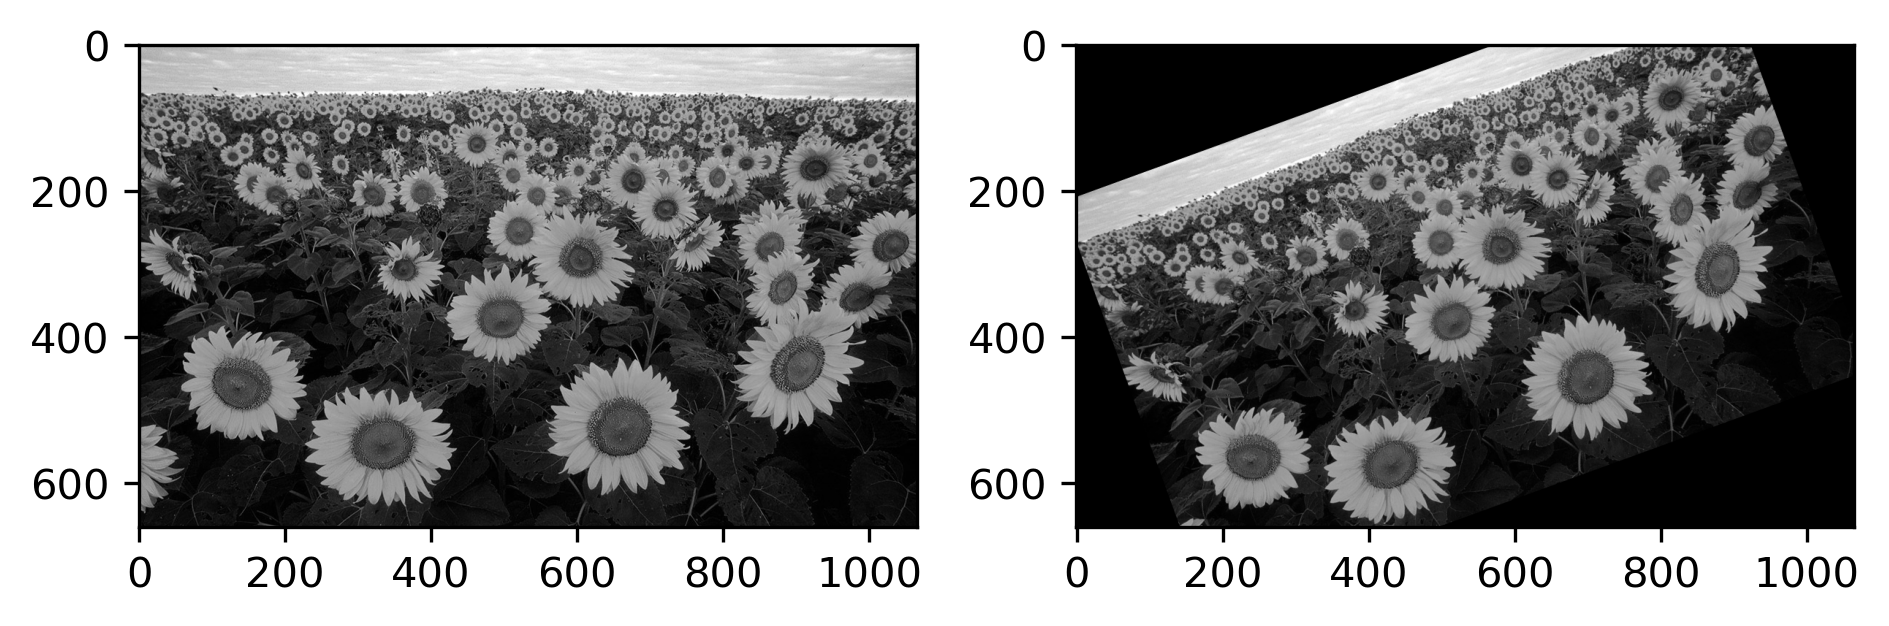

In [166]:
# 9.4
def transformIm(im:np.ndarray, theta:float, s:float) -> np.ndarray:
    """Transform the image im by rotation theta and scaling s"""
    r, c = im.shape
    M = cv2.getRotationMatrix2D((c/2, r/2), theta, s)
    return cv2.warpAffine(im, M, (c, r))
theta = 20; s = 0.9
imu = cv2.imread('data/sunflowers.jpg')[:,:,::-1]
imu = imu.mean(2).astype(np.uint8)
r_im = transformIm(imu, theta, s)
fig, ax = plt.subplots(1, 2 ,dpi=300,tight_layout=True)
ax[0].imshow(imu, cmap='gray')
ax[1].imshow(r_im, cmap='gray');

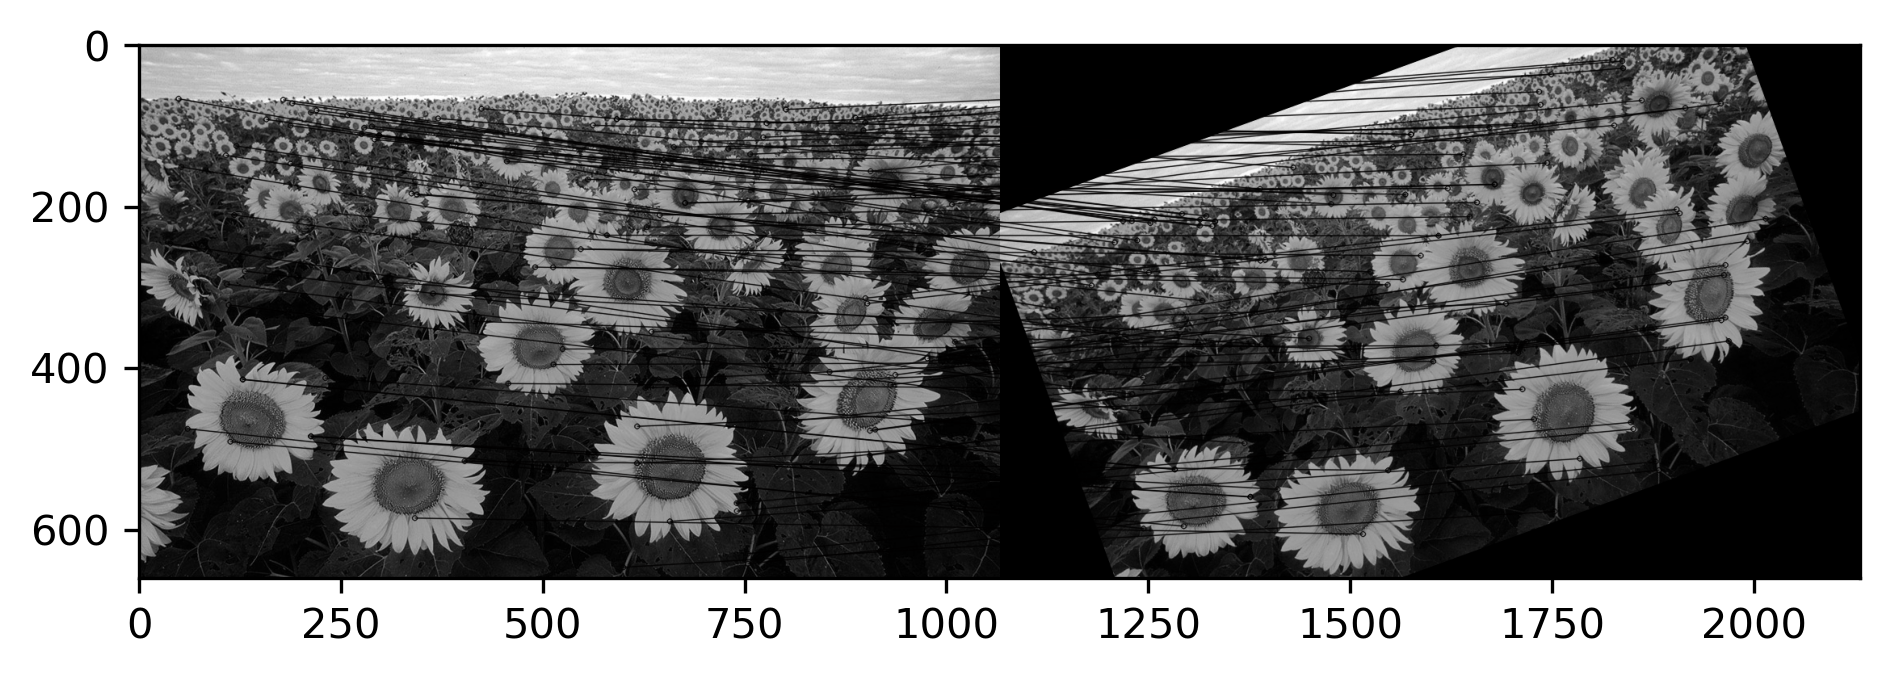

In [167]:
sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(imu, None)
kp2, des2 = sift.detectAndCompute(r_im, None)
bf = cv2.BFMatcher_create(crossCheck=True)
matches = bf.match(des1, des2)
# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)
# draw first 100 matches. to not pollute the image too much
img3 = cv2.drawMatches(imu, kp1, r_im, kp2, matches[:100], None, 1, flags=2)
fig, ax = plt.subplots(dpi=300, tight_layout=True)
ax.imshow(img3, cmap='gray');

In [168]:
F, inliers  = RANSAC(matches, 3.84*3**2, 200, adaptive=False, p=0.99)

In [177]:
display(len(matches))
inlier_matches = np.array(matches)[inliers]
len(inlier_matches)

4027

3731

Only reduces the number of inliers by 300

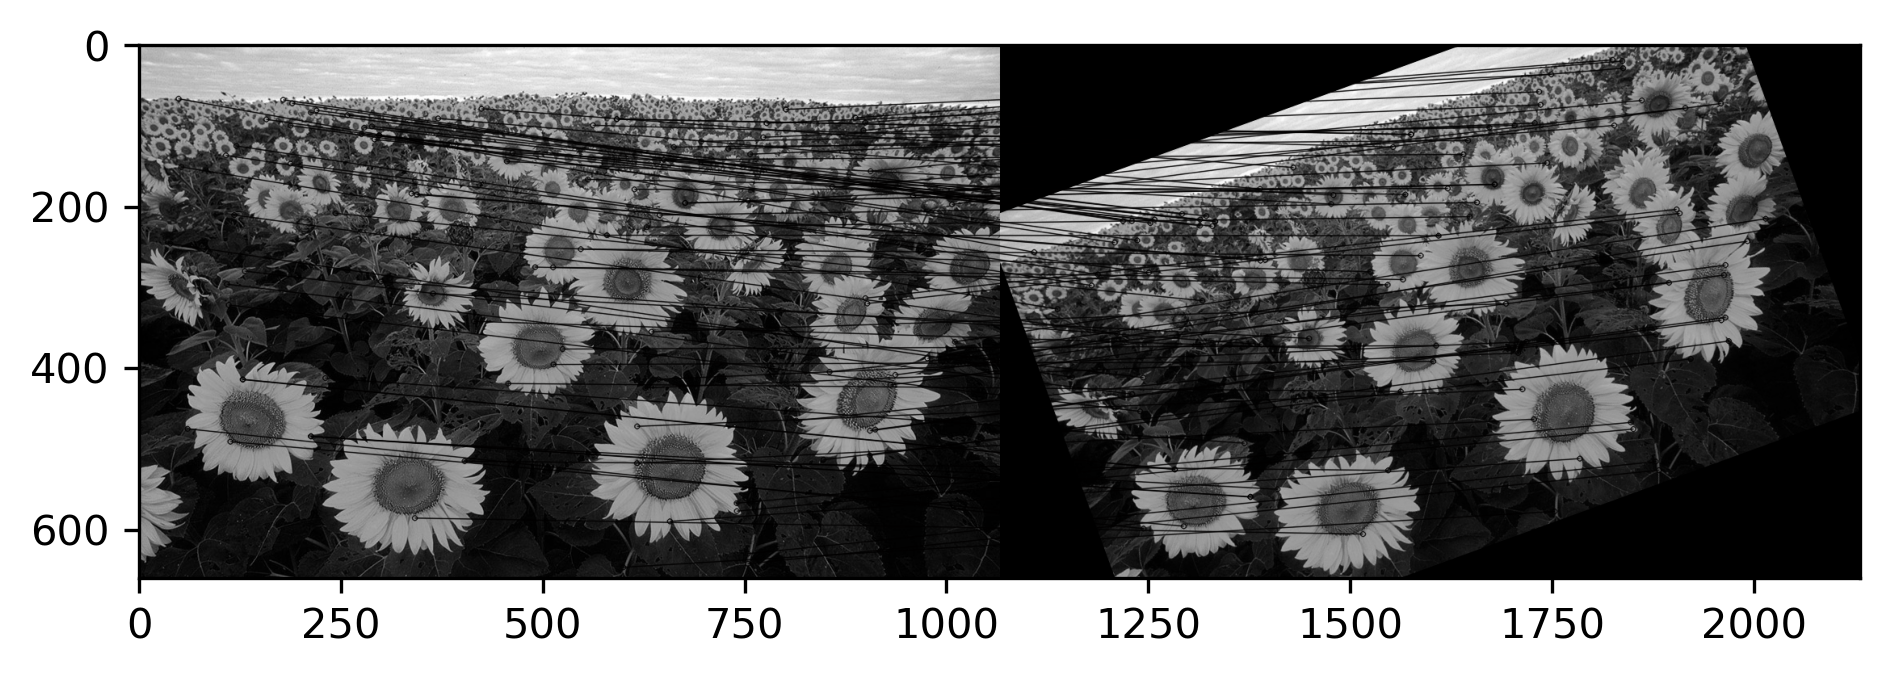

In [175]:
img3 = cv2.drawMatches(imu, kp1, r_im, kp2, inlier_matches[:100], None, 1, flags=2)
fig, ax = plt.subplots(dpi=300, tight_layout=True)
ax.imshow(img3, cmap='gray');